In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve



from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix

from sklearn.model_selection import GridSearchCV



from sklearn.metrics import (accuracy_score, log_loss, classification_report)


import warnings

In [2]:
df = pd.read_pickle('./df.pkl')

In [3]:
cols_to_drop = (['EmployeeCount', 'MaritalStatus', 'Over18', 'StandardHours', 'PerformanceRating', 'EmployeeNumber', 'DailyRate', 'HourlyRate', 'MonthlyRate'])

In [4]:
df = df.drop(columns=cols_to_drop)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EnvironmentSatisfaction   1470 non-null   int64 
 8   Gender                    1470 non-null   object
 9   JobInvolvement            1470 non-null   int64 
 10  JobLevel                  1470 non-null   int64 
 11  JobRole                   1470 non-null   object
 12  JobSatisfaction           1470 non-null   int64 
 13  MonthlyIncome             1470 non-null   int64 
 14  NumCompaniesWorked      

In [6]:
df['JobRole'].value_counts()

Sales Executive              326
Research Scientist           292
Laboratory Technician        259
Manufacturing Director       145
Healthcare Representative    131
Manager                      102
Sales Representative          83
Research Director             80
Human Resources               52
Name: JobRole, dtype: int64

In [7]:
df['NumCompaniesWorked'].value_counts

<bound method IndexOpsMixin.value_counts of 0       8
1       1
2       6
3       1
4       9
       ..
1465    4
1466    4
1467    1
1468    2
1469    2
Name: NumCompaniesWorked, Length: 1470, dtype: int64>

In [8]:
df = df[df['MonthlyIncome'] < 12000]
df = df[df['YearsSinceLastPromotion'] < 6]
df = df[df['YearsWithCurrManager'] < 15]
df = df[df['TotalWorkingYears'] < 21]
df = df[df['TrainingTimesLastYear'] < 5]
df = df[df['YearsAtCompany'] < 17]
df = df[df['YearsInCurrentRole'] < 15]
df = df[df['JobLevel'] < 3.5]


In [9]:
# Add to final EDA Notebook

df = df[df.TotalWorkingYears != 0]
df = df[df.NumCompaniesWorked != 0]

df['AvgTenure'] = df['TotalWorkingYears'] / df['NumCompaniesWorked']

In [10]:
X = df.drop(columns = ['Attrition'])

y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=df['JobRole'])

# Best Model

###

#### OneHotPipeline

In [11]:
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()

num_pipeline = Pipeline([('numnorm', scaler)])

obj_pipeline = Pipeline([('one-hot-encoder', OneHotEncoder(sparse=False)), ('scaling', scaler)])

ct = ColumnTransformer([('num_scale', num_pipeline, X_train.select_dtypes(['float', 'int64']).columns),
                        ('one_hotscale', obj_pipeline, X_train.select_dtypes(['object']).columns)])

### Logitstic Regression

In [12]:
lg_pipe = Pipeline([('ct', ct), ('logreg', LogisticRegression(solver= 'liblinear', C = .1, random_state=42))])

In [13]:
lg_pipe.fit(X_train, y_train);

In [14]:
y_pred = lg_pipe.predict(X_test)


In [15]:
print("Model: C ")
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("__"*40)
print(" ")
print(classification_report(y_test, y_pred))

Model: C 
Accuracy score: 0.86875
________________________________________________________________________________
 
              precision    recall  f1-score   support

          No       0.90      0.94      0.92       127
         Yes       0.71      0.61      0.66        33

    accuracy                           0.87       160
   macro avg       0.81      0.77      0.79       160
weighted avg       0.86      0.87      0.86       160



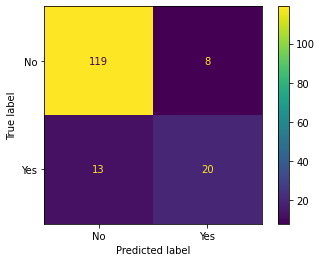

In [16]:
plot_confusion_matrix(lg_pipe, X_test, y_test);

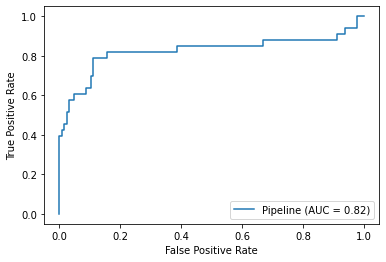

In [17]:
plot_roc_curve(lg_pipe, X_test, y_test);

In [18]:
pipe_grid = {'logreg__penalty': ['l1','l2'] , 'logreg__C': [0.001,0.01,0.1,1,10,100,1000]}

In [19]:
pipe_grid = {'logreg__penalty': ['l2']}

In [20]:
gs_logreg = GridSearchCV(lg_pipe, param_grid = pipe_grid, scoring = 'recall')

In [21]:
# gs_logreg.fit(X_train, y_train)

# gs_logreg.best_params_

# Other Models (trees)

### Ordinal Pipeline

In [22]:
from sklearn.preprocessing import OrdinalEncoder

num_pipeline = Pipeline([('numnorm', StandardScaler())])

obj_pipeline = Pipeline([('ordinal-encoder', OrdinalEncoder()), ('scaling', StandardScaler())])

ct = ColumnTransformer([('scale-numeric', num_pipeline, X_train.select_dtypes(['float', 'int64']).columns),
                        ('ordinal-encoder-scale', obj_pipeline, X_train.select_dtypes(['object']).columns)]) 

# Decision Tree Max Depth 3

In [23]:
clf = tree.DecisionTreeClassifier(max_depth=3)

dtree_pipe = Pipeline([('ct', ct), ('decision-tree-reg', clf)])

In [24]:
dtree_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('scale-numeric',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorking...
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'AvgTenure'],
      dtype='object')),
                                                 ('ordinal-encoder-scale',
                                                  Pipeline(steps=[('ordinal-encoder',
                                                                   OrdinalEncoder()),
                                                                  ('scaling',
    

In [25]:
y_pred = dtree_pipe.predict(X_test)

In [26]:
cross_val_score(dtree_pipe, X_train, y_train)

array([0.7890625 , 0.8046875 , 0.78125   , 0.8046875 , 0.82677165])

In [27]:
# print("Model:")
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("__"*40)
print(" ")
print(classification_report(y_test, y_pred))

Accuracy score: 0.81875
________________________________________________________________________________
 
              precision    recall  f1-score   support

          No       0.82      0.98      0.90       127
         Yes       0.75      0.18      0.29        33

    accuracy                           0.82       160
   macro avg       0.79      0.58      0.59       160
weighted avg       0.81      0.82      0.77       160



In [28]:
# print('Training r^2:', lasso_pipe.score(X_train, y_train))
# print('Test r^2:', lasso_pipe.score(X_test, y_test))
# print('Training MSE:', mean_squared_error(y_train, lasso_pipe.predict(X_train)))
# print('Test MSE:', mean_squared_error(y_test, lasso_pipe.predict(X_test)))

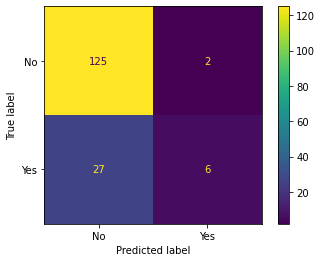

In [29]:
plot_confusion_matrix(dtree_pipe, X_test, y_test);

# XGBoost

In [30]:
from xgboost import XGBRegressor

# Random Forest




In [31]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([('ct', ct),
                      ('model',
                       RandomForestClassifier(n_estimators = 25, min_samples_leaf=5))])

In [32]:
rf_pipe.fit(X_train, y_train);

In [33]:
y_pred = rf_pipe.predict(X_test)

In [34]:
# print("Model:")
print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
print("__"*40)
print(" ")
print(classification_report(y_test, y_pred))

Accuracy score: 0.825
________________________________________________________________________________
 
              precision    recall  f1-score   support

          No       0.82      1.00      0.90       127
         Yes       1.00      0.15      0.26        33

    accuracy                           0.82       160
   macro avg       0.91      0.58      0.58       160
weighted avg       0.86      0.82      0.77       160



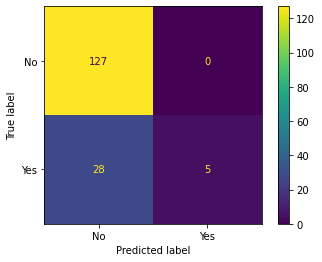

In [35]:
plot_confusion_matrix(rf_pipe, X_test, y_test);

### Grid Search on Random Forest

In [36]:
rf_params = {'model__n_estimators': [25, 50, 75, 100, 125] ,
             'model__min_samples_leaf': [1,3,5,7]}
rf_cv = GridSearchCV(estimator = rf_pipe, param_grid = rf_params, cv = 5)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('scale-numeric',
                                                                         Pipeline(steps=[('numnorm',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'RelationshipSatisfaction',
       'Sto...
                                                                         Pipeline(steps=[('ordinal-encoder',
                                                                                          OrdinalEncoder()),
                                                                                         ('scaling',
 

In [37]:
rf_cv.best_params_

{'model__min_samples_leaf': 5, 'model__n_estimators': 50}